In [556]:
# The purpose of this research project is to evaluate the success of Los Angeles' Slow Street Ordinances in increasing parks and recreation space access. This is an exploratory research project intended to provide a spatial representation of where Slow Streets have been implemented in Los Angeles thus far.

In [557]:
# Research question: How have Los Angeles' Slow Street Ordinances increased access to outdoor space?

In [558]:
# Import commands
import geopandas
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import contextily as ctx
from sodapy import Socrata
import seaborn as sns
from pointpats import centrography
from matplotlib.patches import Ellipse
import numpy

# For spatial statistics
import esda
from esda.moran import Moran, Moran_Local
import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation
import libpysal as lps

# Graphics
import matplotlib.pyplot as plt
import plotly.express as px
import folium

In [559]:
# Import our physical data layers: parks and streets

streetsLA= gpd.read_file('data/Implemented_Slow_Streets.geojson')
streetsLA2= gpd.read_file('data/Implemented_Slow_Streets.geojson')
parksLA= gpd.read_file('data/parks_poly.geojson')
LAzips = gpd.read_file('data/LA_Zips.geojson')
LAzips2 = gpd.read_file('data/LA_Zips.geojson')
parkpoints = gpd.read_file('data/park_points.geojson')
neighborhoods = gpd.read_file('data/LA_Times_Neighborhood_Boundaries.geojson')

# Import our park accessibility indicators

walkLA= gpd.read_file('data/WalkLA150min.geojson')
neighborhoodparks= gpd.read_file('data/Aggregation_of_Parks_NeighborhoodsLA.geojson')
parkneed= gpd.read_file('data/Level_of_Park_Need.geojson')
deficientneighborhoods= gpd.read_file('data/Neighborhoods_Without_Access.geojson')
walkableneighborhoods= gpd.read_file('data/SafeWalk_Neighborhoods.geojson')
walkabilityindex= gpd.read_file('data/Walkability_Index_Score_2012.geojson')
equity= gpd.read_file('data/Community_Health_and_Equity_Index_(2013).geojson')

# Import our health data

obese = gpd.read_file('data/ObeseLA.geojson')
heart = gpd.read_file('data/HeartLA.json')
asthma = gpd.read_file('data/Asthma.geojson')

In [560]:
# We need to join the LA streets data with its designated neighborhood

join = gpd.sjoin(streetsLA, neighborhoods, how='left')

# Let's relabel the columns we want
join = join[['name_left', 'description', 'name_right', 'geometry']]
join.columns = ['Street Name', 'Listed Neighborhood', 'Actual Neighborhood', 'geometry']
join.head()

# How many slow streets does each neighborhood have?
neighborhood_count = join['Actual Neighborhood'].value_counts()
neighborhood_count = neighborhood_count.reset_index()

neighborhood_count.columns = ['name', 'Count']
neighborhood_count.head()

name  Count
0   East Hollywood     15
1         Sawtelle     13
2          Del Rey     11
3  North Hollywood     11
4   Jefferson Park     10

In [561]:
# We need to join the LA streets data with its designated zip code as well, since neighborhoods is a smaller scale than zip

join = gpd.sjoin(streetsLA, LAzips, how='left')

# How many slow streets does each zipcode have?

zips_count = join['ZIPCODE'].value_counts()
zips_count = zips_count.reset_index()

# Let's relabel the columns we want
zips_count.columns = ['ZIPCODE', 'Count']
zips_count.head()

ZIPCODE  Count
0   91601     16
1   90029     13
2   90034     10
3   90027     10
4   90018     10

In [562]:
#I would also like to join our park layer to our zip code layer

join2 = gpd.sjoin(parkpoints, LAzips, how='left')

In [563]:
# How many parks are in each LA zip code?

parks_count = join2['ZIPCODE'].value_counts()
parks_count = parks_count.reset_index()
parks_count.describe()

ZIPCODE
count  86.000000
mean    3.348837
std     2.712791
min     1.000000
25%     1.000000
50%     3.000000
75%     4.000000
max    17.000000

In [564]:
# How many slow streets have been implemented?

neighborhood_count.sum()

name     East HollywoodSawtelleDel ReyNorth HollywoodJe...
Count                                                  178
dtype: object

In [565]:
# How many slow streets have been implemented per neighborhood?

neighborhood_count.describe()

Count
count  28.000000
mean    6.357143
std     3.623118
min     1.000000
25%     4.000000
50%     6.000000
75%     8.250000
max    15.000000

In [566]:
# Which neighborhoods had the most slow streets implemented?

neighborhood_count.tail(30)

name  Count
0           East Hollywood     15
1                 Sawtelle     13
2                  Del Rey     11
3          North Hollywood     11
4           Jefferson Park     10
5           Valley Village     10
6                Koreatown      9
7                    Watts      8
8               Eagle Rock      8
9                    Palms      7
10               Los Feliz      7
11  Historic South-Central      7
12           Highland Park      6
13           Vermont Vista      6
14                Westlake      6
15            Cypress Park      6
16              Wilmington      5
17             Studio City      5
18                Mid-City      5
19           Boyle Heights      4
20           Beverly Grove      4
21         Adams-Normandie      4
22               Hollywood      4
23          Pico-Robertson      2
24                 Fairfax      2
25             Playa Vista      1
26               Brentwood      1
27            Mid-Wilshire      1

In [567]:
# How many slow streets have been implemented per zip code?

zips_count.describe()

Count
count  35.000000
mean    5.371429
std     3.589902
min     1.000000
25%     2.500000
50%     4.000000
75%     7.500000
max    16.000000

In [568]:
# We now need to re-merge the data together.
# The zip code street counts need to be merged with the zip code data set to capture each geometry.
# Neighborhood street counts need to be merged back with neighborhood geometry.

LAzips=LAzips.merge(zips_count,on='ZIPCODE')
neighborhoods=neighborhoods.merge(neighborhood_count,on='name')

In [569]:
#Let's drop any null values and reset our columns

parkpoints.loc[parkpoints['CATEGORY']== 'NaN']
parkpoints.loc[parkpoints['FACNAME']== 'NaN']
parkpoints= parkpoints[['FACNAME','CATEGORY', 'geometry']]

In [570]:
# Project our data so we can plot

parksLA = parksLA.to_crs(epsg=3857)
parkpoints = parkpoints.to_crs(epsg=3857)
streetsLA = streetsLA.to_crs(epsg=3857)
neighborhoods = neighborhoods.to_crs(epsg=3857)
LAzips = LAzips.to_crs(epsg=3857)
LAzips2 = LAzips2.to_crs(epsg=3857)
walkLA= walkLA.to_crs(epsg=3857)
neighborhoodparks= neighborhoodparks.to_crs(epsg=3857)
parkneed= parkneed.to_crs(epsg=3857)
deficientneighborhoods= deficientneighborhoods.to_crs(epsg=3857)
walkableneighborhoods= walkableneighborhoods.to_crs(epsg=3857)
walkabilityindex= walkabilityindex.to_crs(epsg=3857)
equity= equity.to_crs(epsg=3857)

In [571]:
# Let's make some bars and histograms before we map!

Text(0, 0.5, 'Neighborhoods')

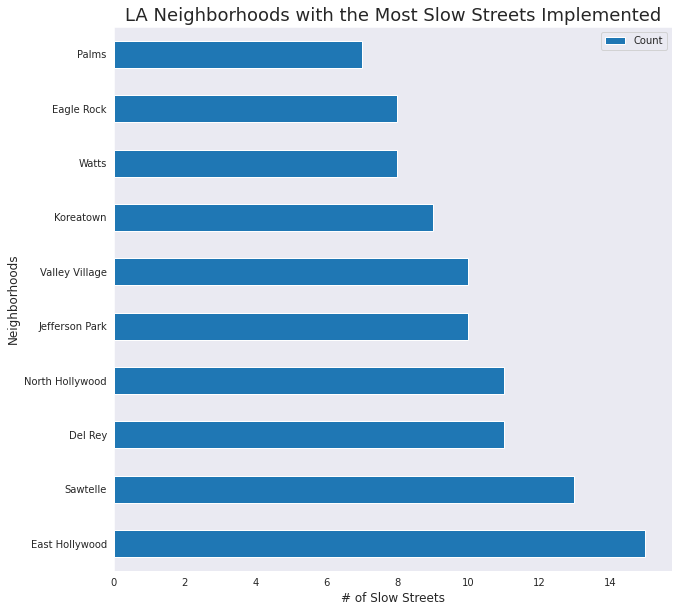

In [572]:
# Neighborhoods with the most Slow Streets Implemented

neighborhood_count[:10].plot.barh(figsize=(10,10),
                             y='Count',
                             x='name')
plt.title('LA Neighborhoods with the Most Slow Streets Implemented',fontsize=18)

plt.xlabel('# of Slow Streets', fontsize=12)
plt.ylabel('Neighborhoods', fontsize=12)

Text(0.5, 0, '# of Slow Streets')

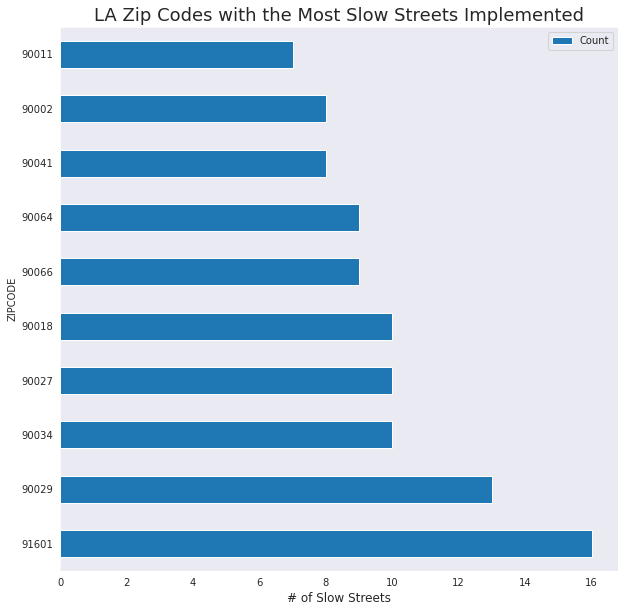

In [573]:
# Zip Codes with the Most Slow Streets Implemented

streets_count[:10].plot.barh(figsize=(10,10),
                             x='ZIPCODE',
                             y='Count')
plt.title('LA Zip Codes with the Most Slow Streets Implemented', fontsize=18)

plt.xlabel('# of Slow Streets', fontsize=12)

Text(0, 0.5, 'Frequency')

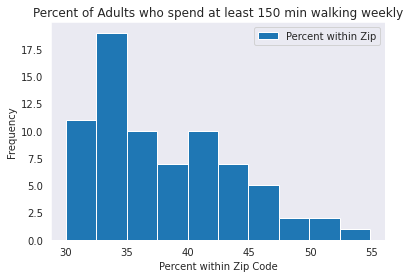

In [574]:
# Calculate % of Adults who walk at least 150 min per week and then make a histogram
walkLA_count = walkLA['Percent_'].value_counts()
walkLA_count = walkLA_count.reset_index()
walkLA_count.columns = ['Percent within Zip', 'Zip Code Frequency']

# Make a histogram showing results
walkLA_count.plot.hist(x= 'Zip Code Frequency', y='Percent within Zip')
plt.title('Percent of Adults who spend at least 150 min walking weekly')
plt.xlabel('Percent within Zip Code')
plt.ylabel('Frequency')


Text(0.5, 1.0, 'Walks at least 150 minutes per week in Los Angeles (2013-2014)')

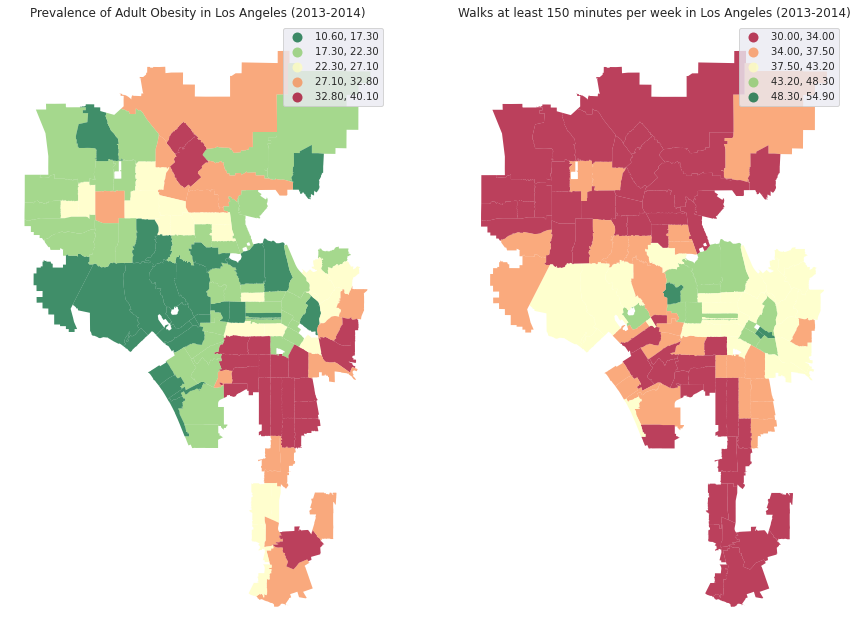

In [575]:
# create the 1x2 subplots for obesity and walking rates

fig, axs = plt.subplots(1, 2, figsize=(15, 12))

# name each subplot
ax1, ax2 = axs 

# regular count map on the left
obese.plot(column='Percent_', 
            cmap='RdYlGn_r', 
            scheme='NaturalBreaks',
            k=5, 
            edgecolor='white', 
            linewidth=0., 
            alpha=0.75, 
            ax=ax1, # this assigns the map to the subplot,
            legend=True
           )

ax1.axis("off")
ax1.set_title("Prevalence of Adult Obesity in Los Angeles (2013-2014)")

walkLA.plot(column='Percent_', 
            cmap='RdYlGn', 
            scheme='NaturalBreaks',
            k=5, 
            edgecolor='white', 
            linewidth=0., 
            alpha=0.75, 
            ax=ax2, # this assigns the map to the subplot
            legend=True
          )
ax2.axis("off")
ax2.set_title("Walks at least 150 minutes per week in Los Angeles (2013-2014)")

Text(0.5, 1.0, 'Prevalence of Heart Disease in Los Angeles (2013-2014)')

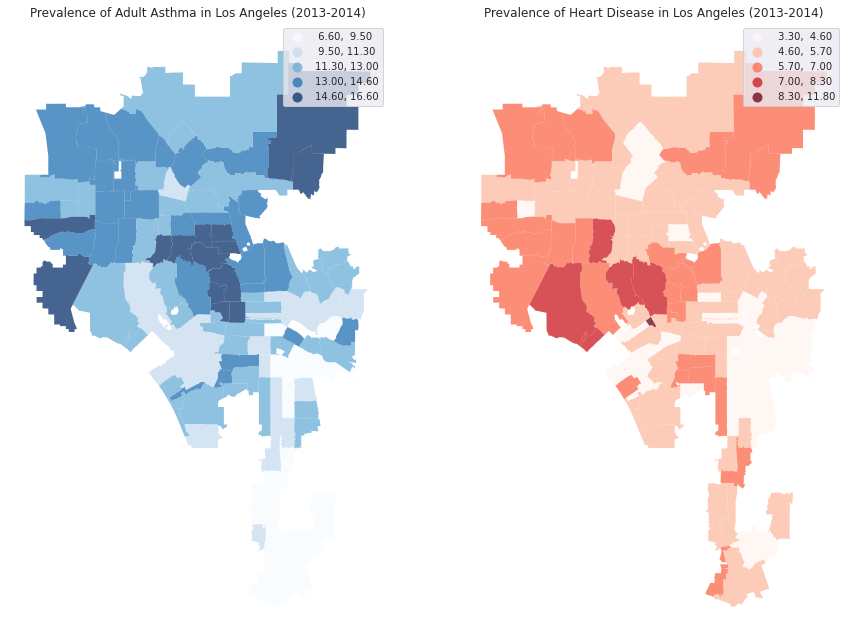

In [576]:
# create the 1x2 subplots for asthma and heart disease

fig, axs = plt.subplots(1, 2, figsize=(15, 12))

# name each subplot
ax1, ax2 = axs 

# regular count map on the left
asthma.plot(column='Percent_', 
            cmap='Blues', 
            scheme='NaturalBreaks',
            k=5, 
            edgecolor='white', 
            linewidth=0., 
            alpha=0.75, 
            ax=ax1, # this assigns the map to the subplot,
            legend=True
           )

ax1.axis("off")
ax1.set_title("Prevalence of Adult Asthma in Los Angeles (2013-2014)")

heart.plot(column='Percent_', 
            cmap='Reds', 
            scheme='NaturalBreaks',
            k=5, 
            edgecolor='white', 
            linewidth=0., 
            alpha=0.75, 
            ax=ax2, # this assigns the map to the subplot
            legend=True
          )
ax2.axis("off")
ax2.set_title("Prevalence of Heart Disease in Los Angeles (2013-2014)")

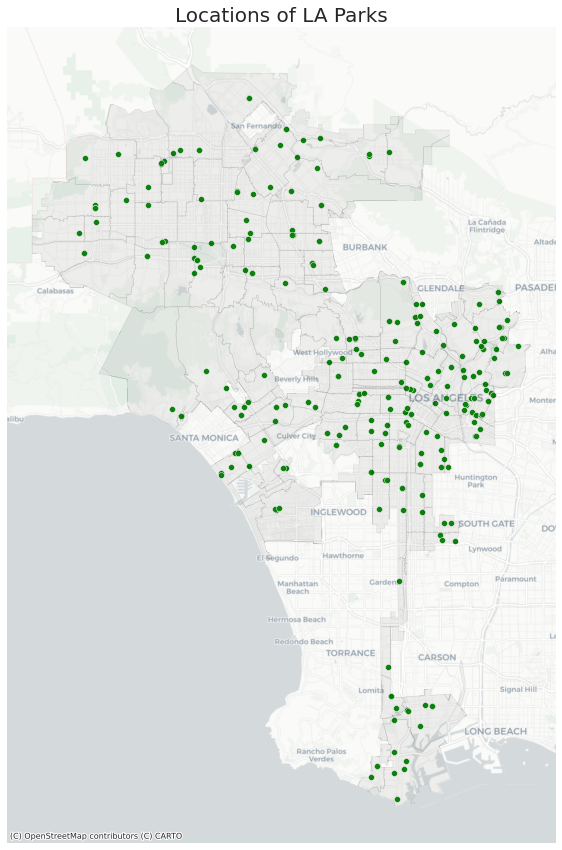

In [577]:
# Plot the point locations of LA parks

fig, ax = plt.subplots(figsize=(15,15))

parkpoints.plot(ax=ax,
         color='green', 
         edgecolor='white',
         lw=0.5,
         alpha=1)

LAzips2.plot(ax=ax,
         color='grey', 
         edgecolor='black',
         lw=0.5,
         alpha=0.1)

# no axis
ax.axis('off')

ax.set_title("Locations of LA Parks", fontsize=20)

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

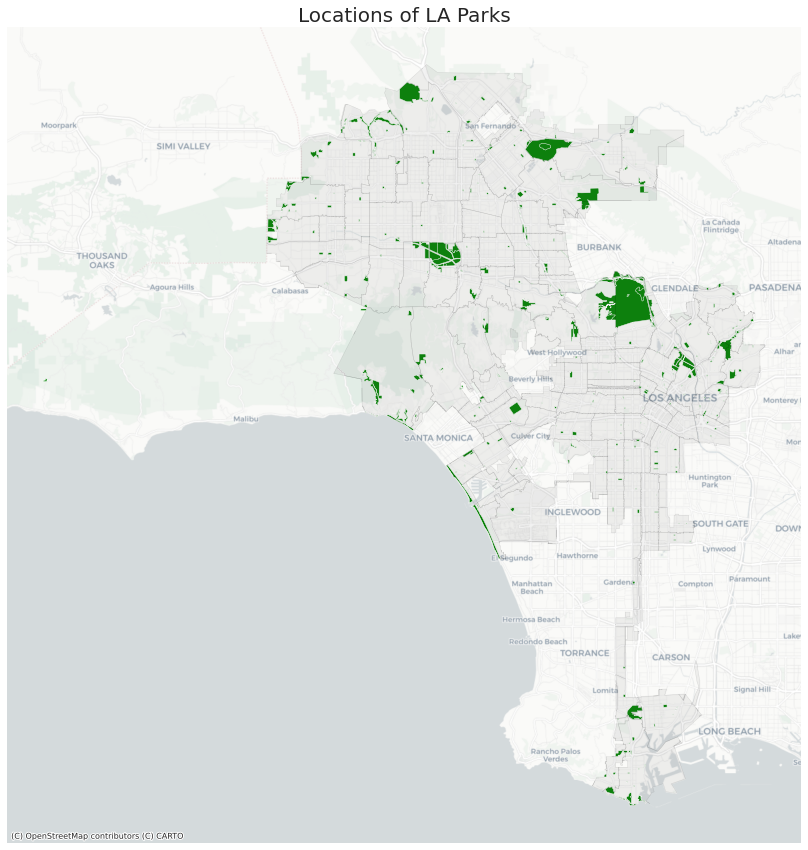

In [578]:
# Plot the polygon boundaries of LA parks

fig, ax = plt.subplots(figsize=(15,15))

parksLA.plot(ax=ax,
         color='green', 
         edgecolor='white',
         lw=0.5,
         alpha=1)

LAzips2.plot(ax=ax,
         color='grey', 
         edgecolor='black',
         lw=0.5,
         alpha=0.1)

# no axis
ax.axis('off')

ax.set_title("Locations of LA Parks", fontsize=20)

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

/opt/conda/lib/python3.8/site-packages/mapclassify/classifiers.py:234: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(
/opt/conda/lib/python3.8/site-packages/mapclassify/classifiers.py:237: UserWarning: Warning: setting k to 3
  Warn("Warning: setting k to %d" % k_q, UserWarning)


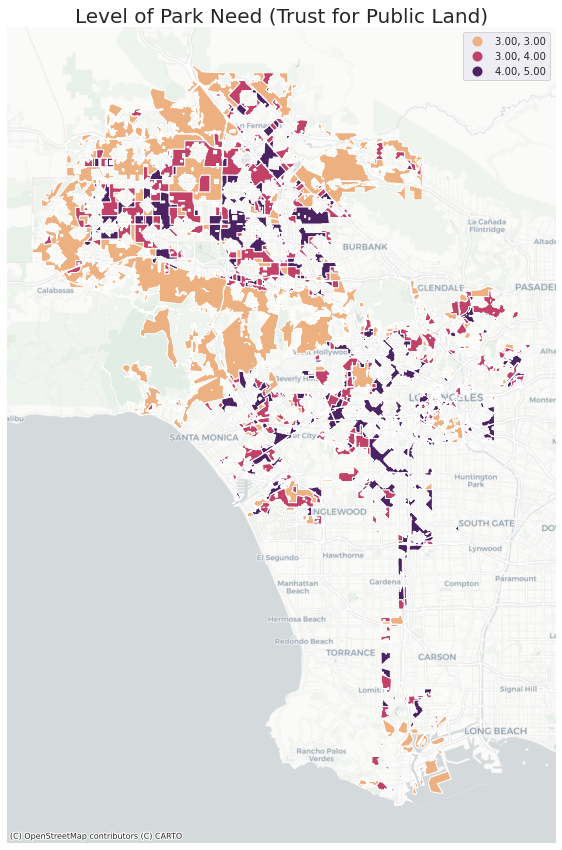

In [579]:
# Plot the Park Need Index Scores

fig, ax = plt.subplots(figsize=(15,15))

parkneed.plot(ax=ax,
        column='gridcode',
        legend=True,
        alpha=1,
        cmap='flare',
        scheme='quantiles')

# no axis
ax.axis('off')

ax.set_title("Level of Park Need (Trust for Public Land)", fontsize=20)

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)


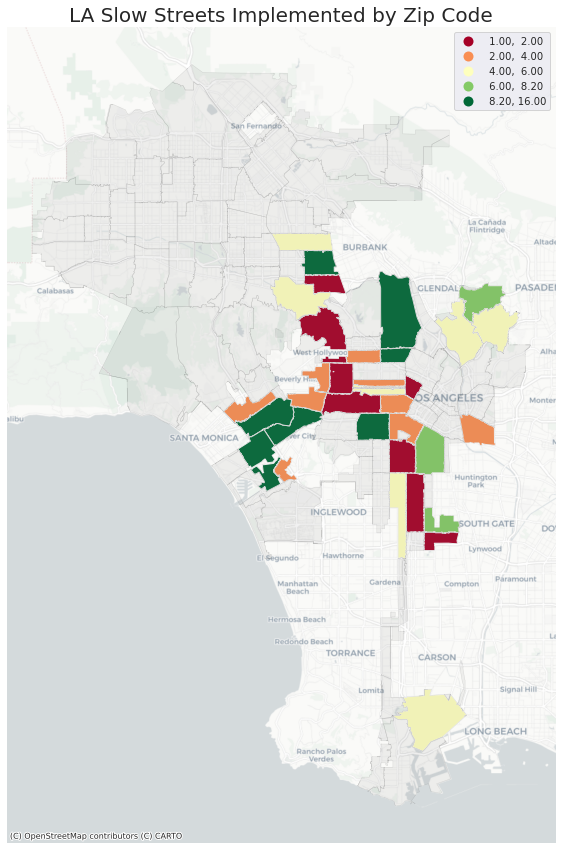

In [580]:
# Plot the Slow Streets Implemented by Zip Code count 

fig, ax = plt.subplots(figsize=(15,15))

LAzips.plot(ax=ax,
        column='Count',
        legend=True,
        alpha=1,
        cmap='RdYlGn',
        scheme='quantiles')

LAzips2.plot(ax=ax,
         color='grey', 
         edgecolor='black',
         lw=0.5,
         alpha=0.1)

# no axis
ax.axis('off')

ax.set_title("LA Slow Streets Implemented by Zip Code", fontsize=20)

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

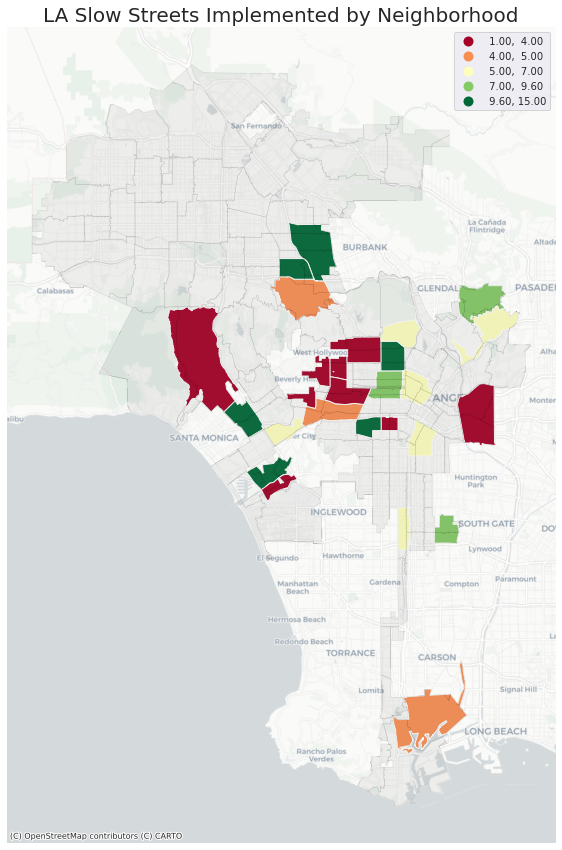

In [581]:
# Plot the Slow Streets Implemented by Neighborhood count 

fig, ax = plt.subplots(figsize=(15,15))

neighborhoods.plot(ax=ax,
        column='Count',
        legend=True,
        alpha=1,
        cmap='RdYlGn',
        scheme='quantiles')

LAzips2.plot(ax=ax,
         color='grey', 
         edgecolor='black',
         lw=0.5,
         alpha=0.1)

# no axis
ax.axis('off')

ax.set_title("LA Slow Streets Implemented by Neighborhood", fontsize=20)

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

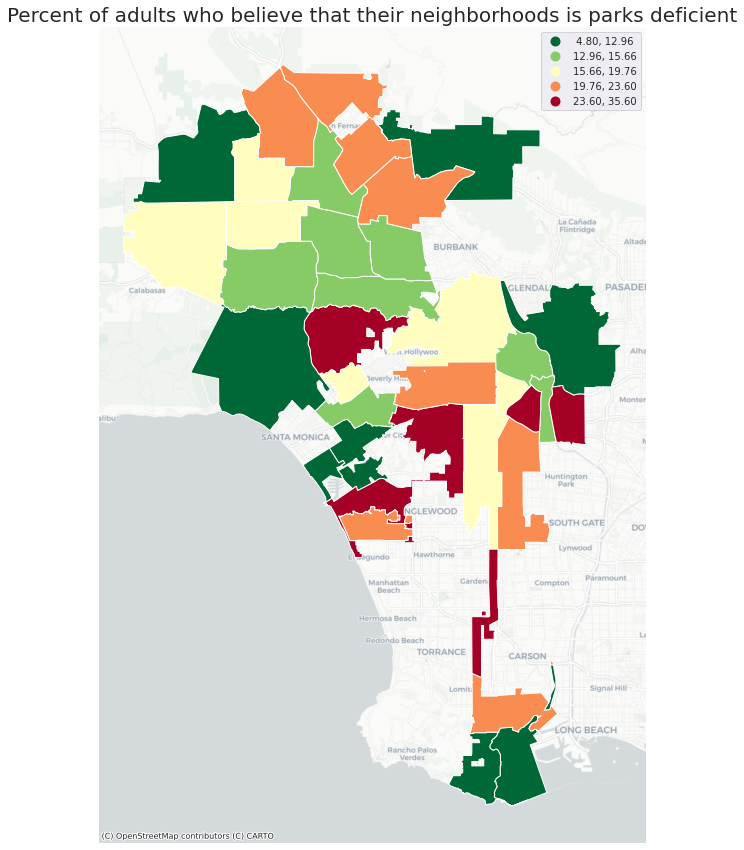

In [582]:
# Plot the perceptions of adults who think their neighborhood is parks deficient

fig, ax = plt.subplots(figsize=(15,15))

deficientneighborhoods.plot(ax=ax,
        column='Percent_',
        legend=True,
        alpha=1,
        cmap='RdYlGn_r',
        scheme='quantiles')

# no axis
ax.axis('off')

ax.set_title("Percent of adults who believe that their neighborhoods is parks deficient", fontsize=20)

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

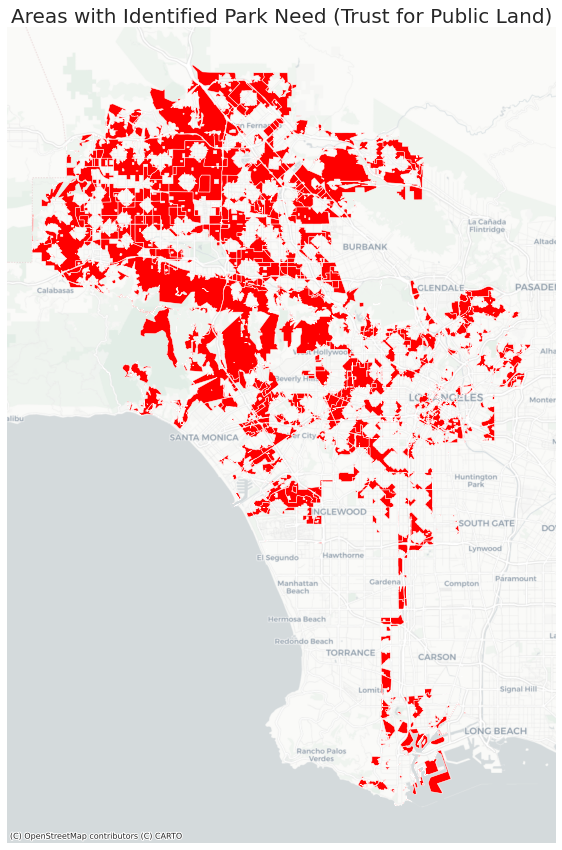

In [583]:
# Plot Trust for Public Land high park need spaces (no scores)

fig, ax = plt.subplots(figsize=(15,15))

parkneed.plot(ax=ax,
         color='red', 
         edgecolor='white',
         lw=0.5,
         alpha=1)

ax.axis("off")
ax.set_title("Areas with Identified Park Need (Trust for Public Land)",fontsize=20)

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

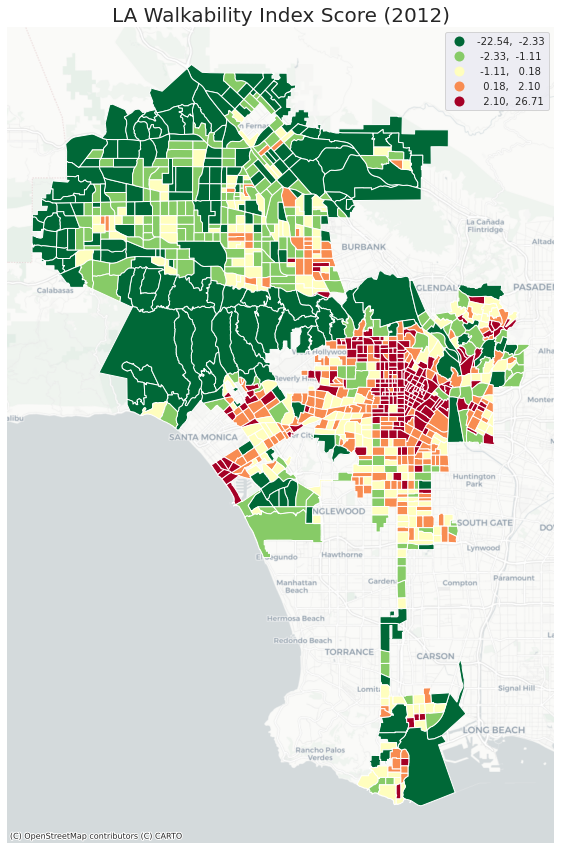

In [586]:
# Plot LA walkability scores

fig, ax = plt.subplots(figsize=(15,15))

walkabilityindex.plot(ax=ax,
        column='Walkabil_1',
        legend=True,
        alpha=1,
        cmap='RdYlGn_r',
        scheme='quantiles')

ax.axis("off")
ax.set_title("LA Walkability Index Score (2012)",fontsize=20)

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

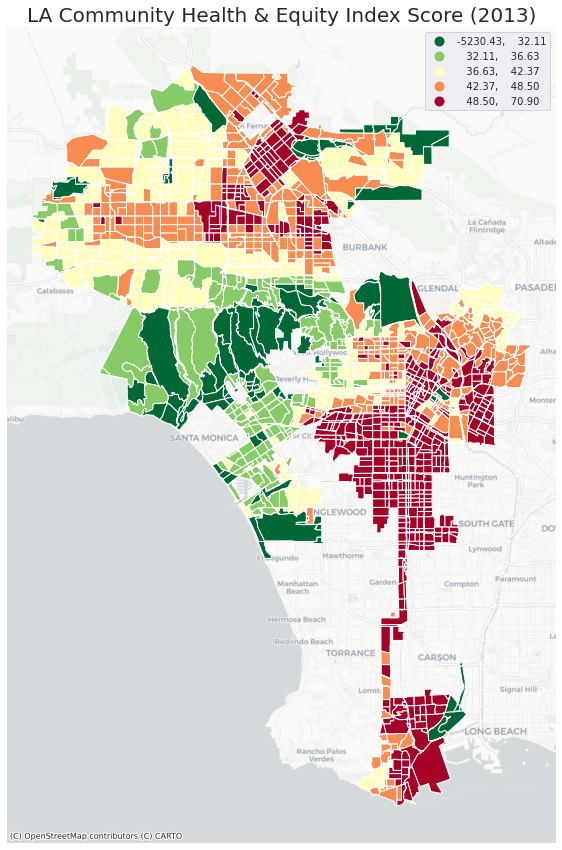

In [587]:
# Plot community health and equity scores

fig, ax = plt.subplots(figsize=(15,15))


equity.plot(ax=ax,
        column='HD_IND_W',
        legend=True,
        alpha=1,
        cmap='RdYlGn_r',
        scheme='quantiles')

ax.axis("off")
ax.set_title("LA Community Health & Equity Index Score (2013)",fontsize=20)

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

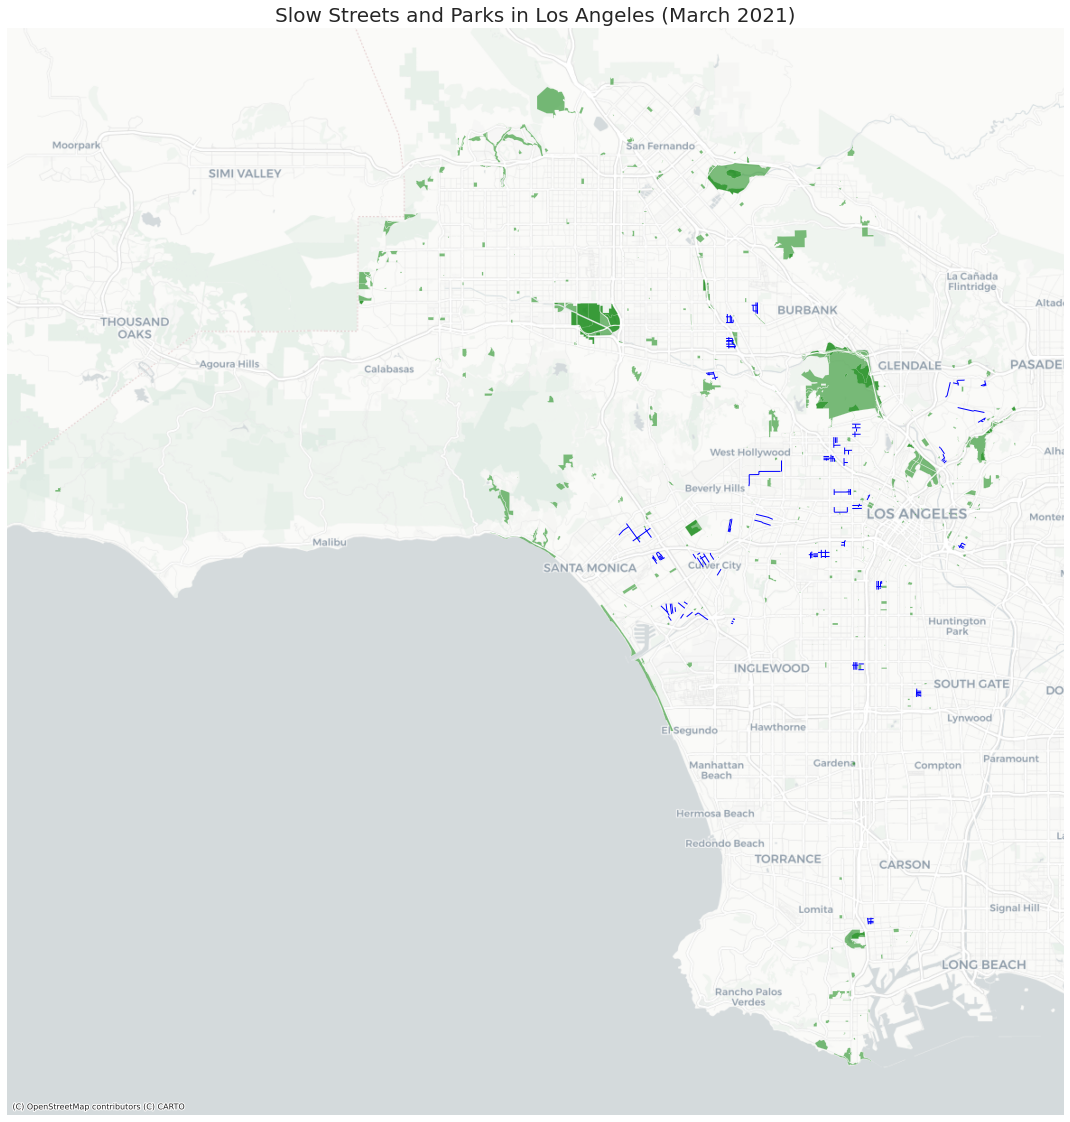

In [588]:
# Plot both slow streets and park locations in Los Angeles

fig, ax = plt.subplots(figsize=(20,20))

streetsLA.plot(ax=ax,
         color='blue', 
         edgecolor='black',
         lw=1,
         alpha=1)

parksLA.plot(ax=ax,
         color='green', 
         edgecolor='white',
         lw=0.25,
         alpha=0.5)

ax.axis("off")
ax.set_title("Slow Streets and Parks in Los Angeles (March 2021)",fontsize=20)

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

In [589]:
# Project the map so we can save as an interactive html

m = folium.Map(
    location=[34.00158291566265, -118.251045313253],
    tiles="cartodbpositron",
    zoom_start=10,
)

folium.GeoJson(streetsLA).add_to(m)
m

In [590]:
m.save(outfile='streetsmap.html')

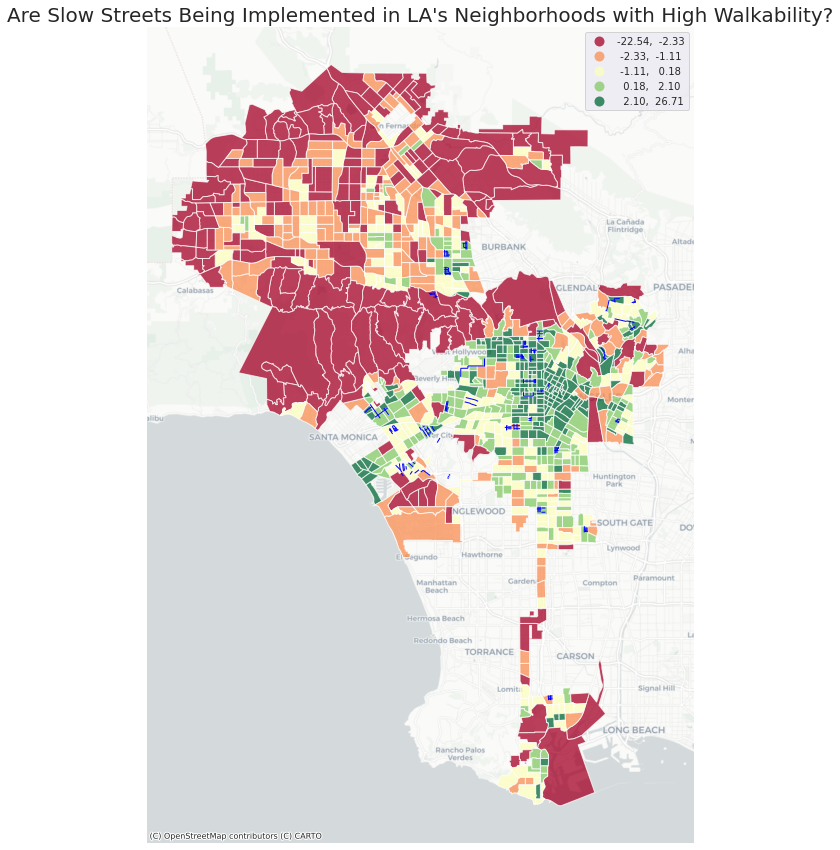

In [591]:
# Comparison of LA walkability scores to slow street ordinances

fig, ax = plt.subplots(figsize=(15,15))

streetsLA.plot(ax=ax,
         color='blue', 
         edgecolor='black',
         lw=1,
         alpha=1)

walkabilityindex.plot(ax=ax,
        column='Walkabil_1',
        legend=True,
        alpha=0.75,
        cmap='RdYlGn',
        scheme='quantiles')

ax.axis("off")
ax.set_title("Are Slow Streets Being Implemented in LA's Neighborhoods with High Walkability?",fontsize=20)

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

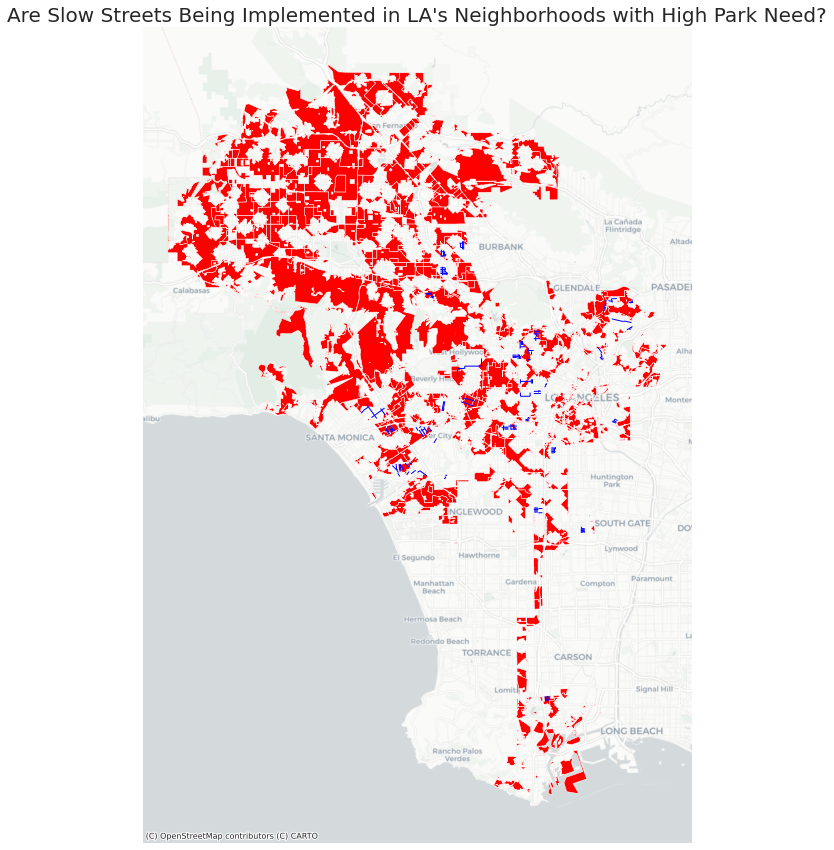

In [592]:
# Comparison of LA park need to slow street ordinances

fig, ax = plt.subplots(figsize=(15,15))

streetsLA.plot(ax=ax,
         color='blue', 
         edgecolor='black',
         lw=1,
         alpha=1)

parkneed.plot(ax=ax,
         color='red', 
         edgecolor='white',
         lw=0.5,
         alpha=1)

ax.axis("off")
ax.set_title("Are Slow Streets Being Implemented in LA's Neighborhoods with High Park Need?",fontsize=20)

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

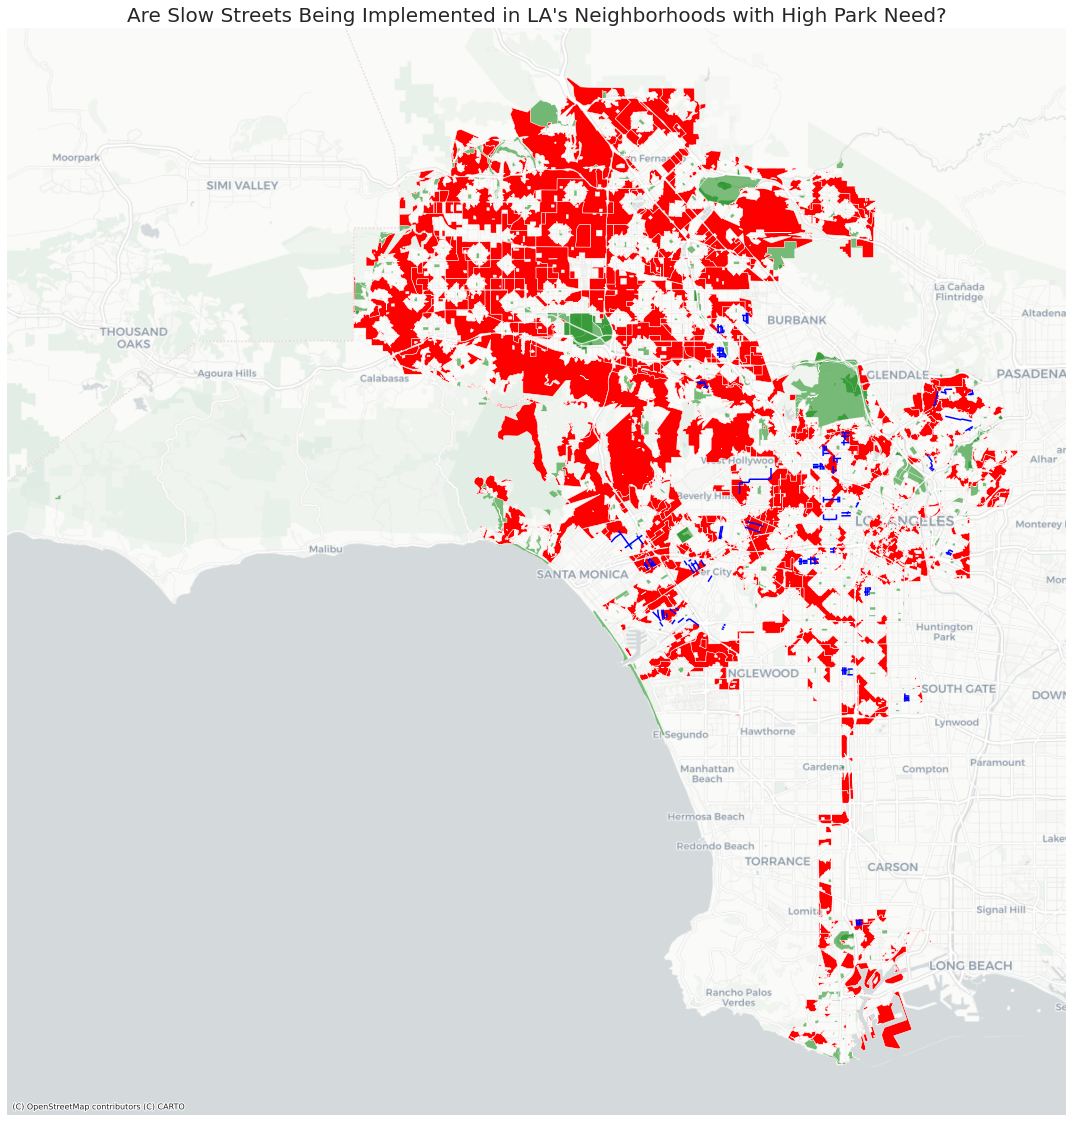

In [593]:
# Comparison of LA park need to slow street ordinances (with parks)

fig, ax = plt.subplots(figsize=(20,20))

streetsLA.plot(ax=ax,
         color='blue', 
         edgecolor='black',
         lw=1.5,
         alpha=2)

parksLA.plot(ax=ax,
         color='green', 
         edgecolor='white',
         lw=0.25,
         alpha=0.5)

parkneed.plot(ax=ax,
         color='red', 
         edgecolor='white',
         lw=0.5,
         alpha=1)

ax.axis("off")
ax.set_title("Are Slow Streets Being Implemented in LA's Neighborhoods with High Park Need?",fontsize=20)

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

In [594]:
# Let's do some spatial autocorrelation with our park facilities data since this is the only point data we have.

In [599]:
#Extract x and y data for our park points

parkpoints['x'] = parkpoints.geometry.x
parkpoints['y'] = parkpoints.geometry.y

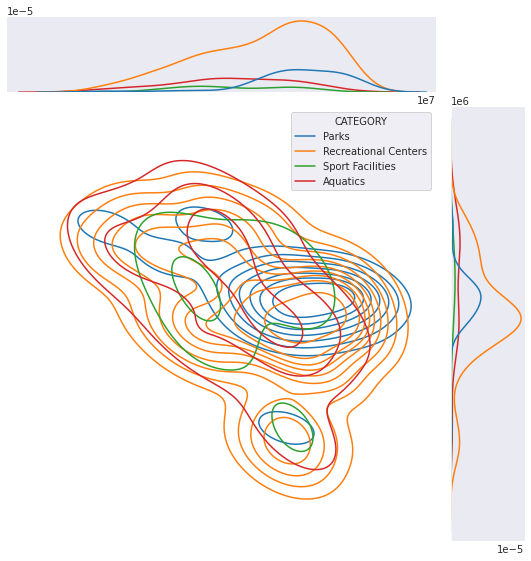

In [596]:
# multiple kde plots by park type
g = sns.jointplot(data = parkpoints,
              x='x', 
              y='y', 
              kind='kde',
              hue='CATEGORY',
              height=8 # make the map bigger
                 )

# Clean axes
g.ax_joint.set_axis_off()

# add basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

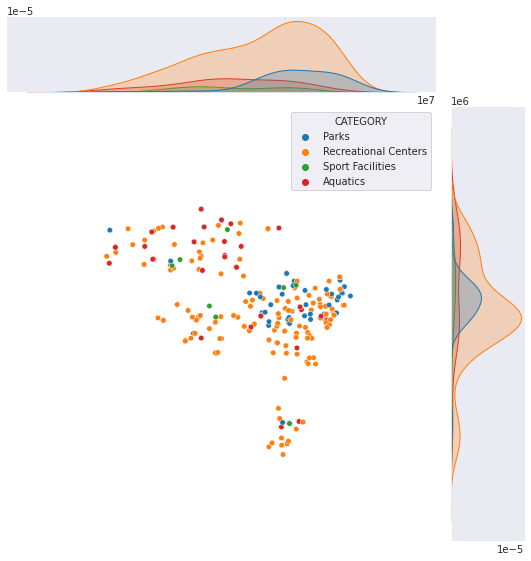

In [600]:
# color code park points by category
g = sns.jointplot(data = parkpoints,
                  x='x', 
                  y='y',
                  hue='CATEGORY',
                  s=30,
                  height=8 # make the map bigger
                 )

# Clean axes
g.ax_joint.set_axis_off()

# add basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

In [601]:
# compute the mean and median centers
mean_center = centrography.mean_center(parkpoints[['x','y']])
med_center = centrography.euclidean_median(parkpoints[['x','y']])

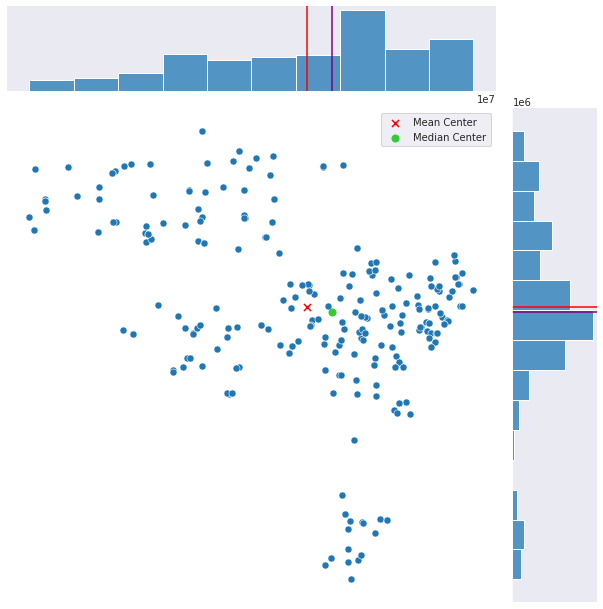

In [602]:
# Generate scatter plot
g = sns.jointplot(
    x='x', y='y', data=parkpoints, s=50, height=9
)

# Add mean point and marginal lines
g.ax_joint.scatter(
    *mean_center, color='red', marker='x', s=50, label='Mean Center'
)
g.ax_marg_x.axvline(mean_center[0], color='red')
g.ax_marg_y.axhline(mean_center[1], color='red')

# Add median point and marginal lines
g.ax_joint.scatter(
    *med_center, color='limegreen', marker='o', s=50, label='Median Center'
)
g.ax_marg_x.axvline(med_center[0], color='purple')
g.ax_marg_y.axhline(med_center[1], color='purple')

# Legend
g.ax_joint.legend()

# Clean axes
g.ax_joint.set_axis_off()

ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

# Display
plt.show()

In [603]:
major, minor, rotation = centrography.ellipse(parkpoints[['x','y']])

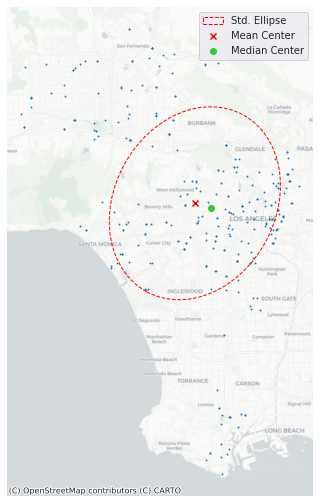

In [604]:
# set the style without grid lines
sns.set_style('dark')

# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))

# Plot points
ax.scatter(parkpoints['x'], parkpoints['y'], s=0.75)
ax.scatter(*mean_center, color='red', marker='x', label='Mean Center')
ax.scatter(*med_center, color='limegreen', marker='o', label='Median Center')

# Construct the standard ellipse using matplotlib
ellipse = Ellipse(xy=mean_center, # center the ellipse on our mean center
                  width=major*2, # centrography.ellipse only gives half the axis
                  height=minor*2, 
                  angle = numpy.rad2deg(rotation), # Angles for this are in degrees, not radians
                  facecolor='none', 
                  edgecolor='red', 
                  linestyle='--',
                  label='Std. Ellipse')

ax.add_patch(ellipse)

ax.legend()

ax.axis('off')

ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

# Display
plt.show()

In [ ]:
# The ultimate goal of this research project was to evaluate of Los Angeles' slow streets implementation has increased access to parks and recreation space. Ultimately, access did increase to outdoor space. 178 spaces have been added for LA residents as of March 2021.

In [ ]:
# However, access to outdoor space did not increase for communities with existing park deficiencies, such as the San Fernando Valley, South LA, South Central LA, or Downtown. 